# Prep

In [1]:
import os
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from math import sqrt 
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

warnings.filterwarnings("ignore")

In [2]:
city_df = pd.read_csv('GlobalLandTemperaturesByCity.csv')
city_df.sort_index(ascending=True, inplace=True)

In [3]:
city_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
def prep_city_data(df):
    '''
    Prepares raw store data for analysis and time series modeling.
    '''
    df['dt'] = pd.to_datetime(city_df.dt)
    df = df.set_index('dt').sort_index()
    return df

In [5]:
city_df = prep_city_data(city_df)

In [6]:
def plot_1():
    by_date = city_df.groupby('dt')['AverageTemperature'].mean()
    by_date.plot(x='dt', y='AverageTemperature')
    city_df.resample('Y')['AverageTemperature'].mean().plot()
    city_df.resample('Y')['AverageTemperatureUncertainty'].mean().plot()
    city_df.resample('Y')['AverageTemperatureUncertainty'].mean().plot()

<AxesSubplot: xlabel='dt'>

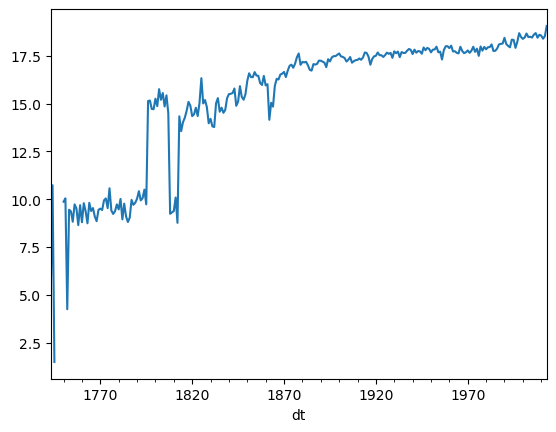

In [7]:
city_df.resample('Y')['AverageTemperature'].mean().plot()

<AxesSubplot: xlabel='dt'>

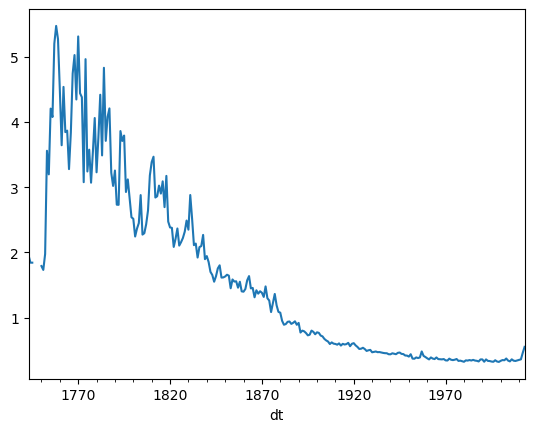

In [8]:
city_df.resample('Y')['AverageTemperatureUncertainty'].mean().plot()

# Splitting

###### Human Based

In [9]:
def data_split(df):
    df_resampled = city_df.resample('M')[['AverageTemperature', 'AverageTemperatureUncertainty']].mean().pad()

    df_resampled.shape

    train_size = int(round(df_resampled.shape[0]*0.5))
    train_size

    validate_size = int(round(df_resampled.shape[0] * 0.3))
    validate_size

    test_size = int(round(df_resampled.shape[0] * 0.2))
    test_size

    validate_end_index = train_size + validate_size
    validate_end_index

    train = df_resampled[:train_size]
    validate = df_resampled[train_size:validate_end_index]
    test = df_resampled[validate_end_index:]
    return train, validate, test

# Exploring

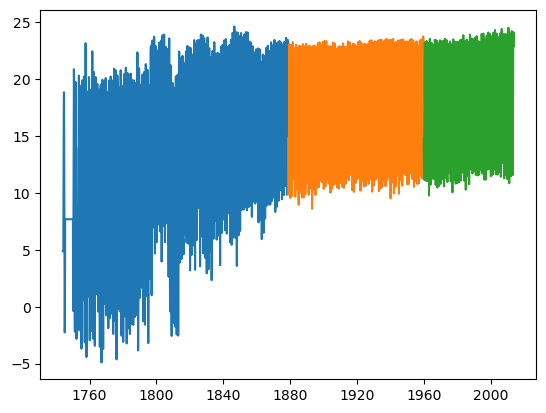

In [16]:
def explore(train, validate, test):   
    plt.plot(train.index, train.AverageTemperature)
    plt.plot(validate.index, validate.AverageTemperature)
    plt.plot(test.index, test.AverageTemperature)
    plt.show()

    plt.hist(train.AverageTemperature)
    plt.xlabel('AverageTemperature')
    plt.ylabel('count')
    plt.title('distribution of Average Temperature')
    plt.show()

    plt.hist(train.AverageTemperatureUncertainty)
    plt.xlabel('AverageTemperatureUncertainty')
    plt.ylabel('count')
    plt.title('distribution of Average Temperature Uncertanity')
    plt.show()

    train.groupby([train.index.year, train.index.month]).mean()

    week_mean=train.resample('W').mean().pad()

    week_mean['shifted'] = week_mean['AverageTemperature'].pad().shift(-2)

    plt.scatter(week_mean['AverageTemperature'].sample(500), week_mean['shifted'].sample(500))
    plt.xlabel('temp this week')
    plt.ylabel('temp next week')
    plt.show()

    week_mean['half_year'] = week_mean['AverageTemperature'].pad().shift(-26)
    week_mean

    plt.scatter(week_mean['AverageTemperature'].sample(200), week_mean['half_year'].sample(200))
    plt.xlabel('temp this week')
    plt.ylabel('temp in half year')
    plt.show()

    pd.plotting.autocorrelation_plot(train.resample('W').mean().pad())
    plt.show()

# Modeling

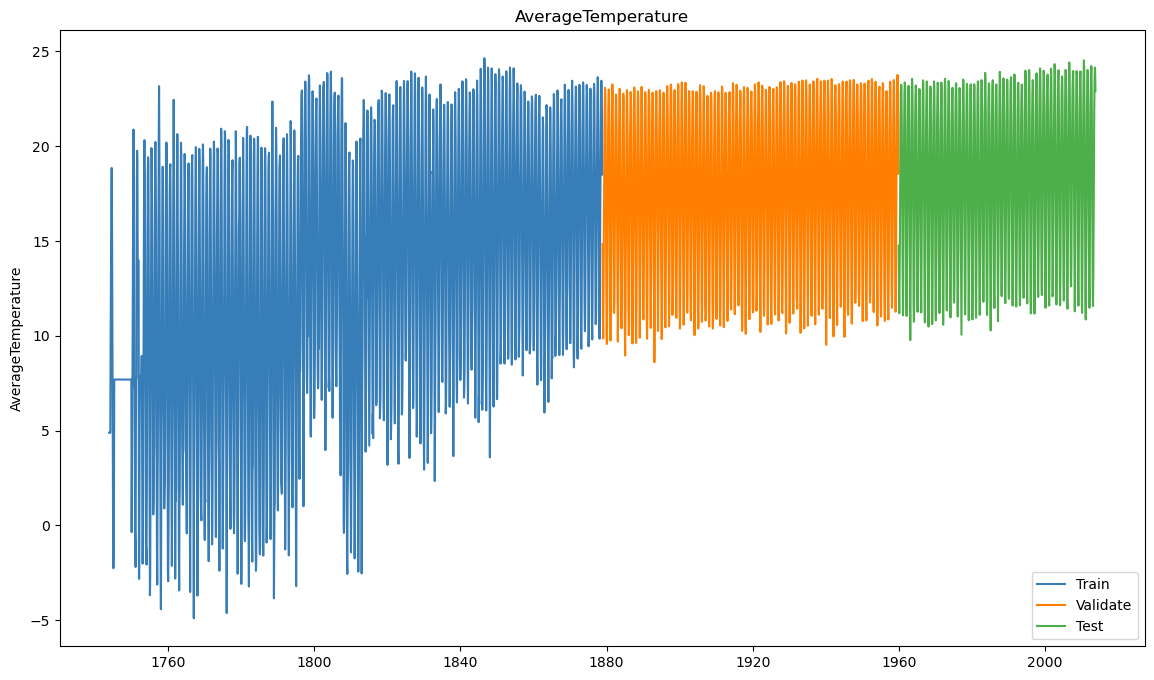

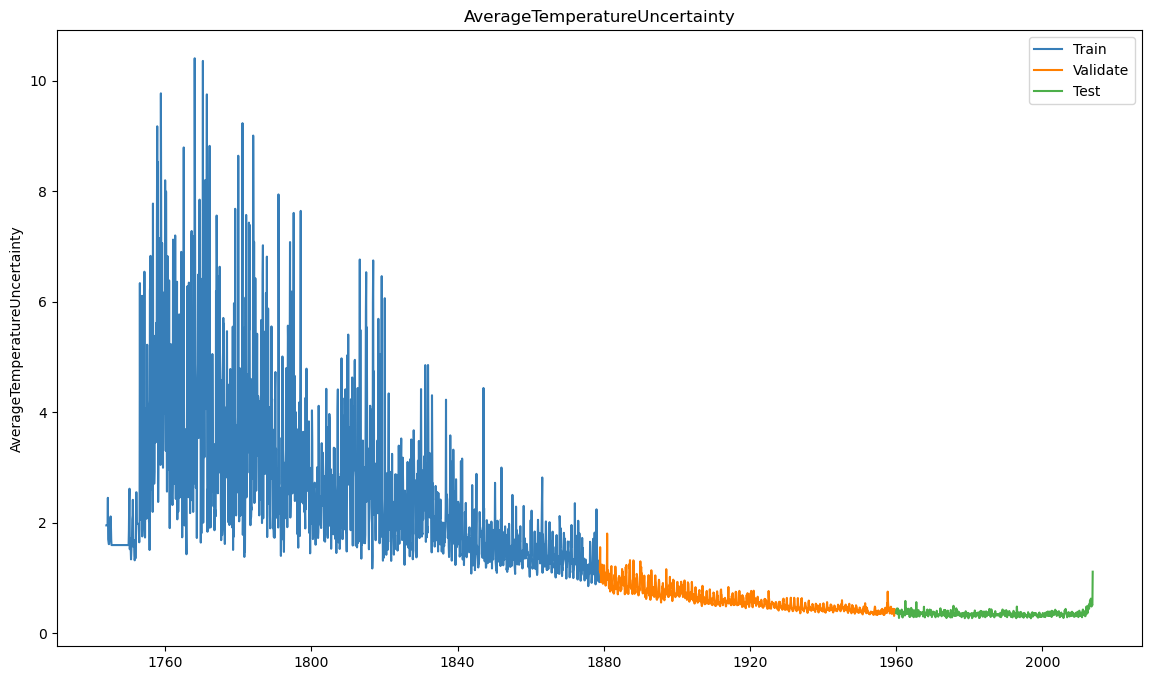

In [26]:
def modeling(train,validate,test):
    for col in train.columns:
        plt.figure(figsize=(14,8))
        plt.plot(train[col], color='#377eb8', label = 'Train')
        plt.plot(validate[col], color='#ff7f00', label = 'Validate')
        plt.plot(test[col], color='#4daf4a', label = 'Test')
        plt.legend()
        plt.ylabel(col)
        plt.title(col)
        plt.show()

    def evaluate(target_var):
        '''
        This function will take the actual values of the target_var from validate, 
        and the predicted values stored in yhat_df, 
        and compute the rmse, rounding to 0 decimal places. 
        it will return the rmse. 
        '''
        rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
        return rmse

    def plot_and_eval(target_var):
        '''
        This function takes in the target var name (string), and returns a plot
        of the values of train for that variable, validate, and the predicted values from yhat_df. 
        it will als lable the rmse. 
        '''
        plt.figure(figsize = (12,4))
        plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
        plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
        plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
        plt.legend()
        plt.title(target_var)
        rmse = evaluate(target_var)
        print(target_var, '-- RMSE: {:.0f}'.format(rmse))
        plt.show()

    eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
    eval_df

    def append_eval_df(model_type, target_var):
        '''
        this function takes in as arguments the type of model run, and the name of the target variable. 
        It returns the eval_df with the rmse appended to it for that model and target_var. 
        '''
        rmse = evaluate(target_var)
        d = {'model_type': [model_type], 'target_var': [target_var],
            'rmse': [rmse]}
        d = pd.DataFrame(d)
        return eval_df.append(d, ignore_index = True)

    train['AverageTemperature'][-1:][0]

    last_temps = train['AverageTemperature'][-1:][0]

    last_avg_temp_unc = train['AverageTemperatureUncertainty'][-1:][0]

    yhat_df = pd.DataFrame(
        {'AverageTemperature': [last_temps],
         'AverageTemperatureUncertainty': [last_avg_temp_unc]},
        index=validate.index)

    yhat_df.head()

    def make_baseline_predictions(sales_predictions=None, quantity_predictions=None):
        yhat_df = pd.DataFrame({'AverageTemperature': [last_temps],
                                'AverageTemperatureUncertainty': [last_avg_temp_unc]},
                               index=validate.index)

        return yhat_df

    for col in train.columns:
        eval_df = append_eval_df(model_type = 'last_observed_value', 
                                 target_var = col)

    eval_df



    period=30
    train['AverageTemperature'].rolling(period).mean()

    period=30
    train['AverageTemperature'].rolling(period).mean()[-1]

    rolling_sales = round(train['AverageTemperature'].rolling(period).mean()[-1], 2)
    rolling_quantity = round(train['AverageTemperatureUncertainty'].rolling(period).mean()[-1], 2)
    print(rolling_sales, rolling_quantity)

    yhat_df = make_baseline_predictions(rolling_sales, rolling_quantity)
    yhat_df.head()

    for col in train.columns:
        eval_df = append_eval_df(model_type = '30d_moving_avg', 
                                target_var = col)

    eval_df

    periods = [4, 12, 26, 52, 104]

    for p in periods: 
        rolling_sales = round(train['AverageTemperature'].rolling(p).mean()[-1], 2)
        rolling_quantity = round(train['AverageTemperatureUncertainty'].rolling(p).mean()[-1], 2)
        yhat_df = make_baseline_predictions(rolling_sales, rolling_quantity)
        model_type = str(p) + '_day_moving_avg'
        for col in train.columns:
            eval_df = append_eval_df(model_type = model_type,
                                    target_var = col)

    best_quantity_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

    best_sales_total_rmse = eval_df[eval_df.target_var == 'sales_total']['rmse'].min()

    eval_df[eval_df.rmse == best_sales_total_rmse]

    for col in train.columns:
        sm.tsa.seasonal_decompose(train[col].resample('W').mean().pad()).plot()

    col = 'AverageTemperature' 
    # create our Holt Object
    model = Holt(train[col], exponential=False, damped=True)

    model = model.fit(optimized=True)

    yhat_amount = model.predict(start = validate.index[0],
                                  end = validate.index[-1])

    for col in train.columns:
        model = Holt(train[col], exponential=False, damped=True)
        model = model.fit(optimized=True)
        yhat_values = model.predict(start = validate.index[0],
                                  end = validate.index[-1])
        yhat_df[col] = round(yhat_values, 2)

    for col in train.columns:
        plot_and_eval(target_var = col)

    # Models for quantity
    hst_quantity_fit1 = ExponentialSmoothing(train.AverageTemperature).fit()
    hst_quantity_fit2 = ExponentialSmoothing(train.AverageTemperature).fit()
    hst_quantity_fit3 = ExponentialSmoothing(train.AverageTemperature).fit()
    hst_quantity_fit4 = ExponentialSmoothing(train.AverageTemperature).fit()

    # Models for sales
    hst_sales_fit1 = ExponentialSmoothing(train.AverageTemperatureUncertainty).fit()
    hst_sales_fit2 = ExponentialSmoothing(train.AverageTemperatureUncertainty).fit()
    hst_sales_fit3 = ExponentialSmoothing(train.AverageTemperatureUncertainty).fit()
    hst_sales_fit4 = ExponentialSmoothing(train.AverageTemperatureUncertainty).fit()

    results_quantity=pd.DataFrame({'model':['hst_quantity_fit1', 'hst_quantity_fit2', 'hst_quantity_fit3', 'hst_quantity_fit4'],
                                  'SSE':[hst_quantity_fit1.sse, hst_quantity_fit2.sse, hst_quantity_fit3.sse, hst_quantity_fit4.sse]})
    results_quantity

    yhat_df = pd.DataFrame({'AverageTemperature': hst_sales_fit1.forecast(validate.shape[0]),
                               'AverageTemperatureUncertainty': hst_quantity_fit1.forecast(validate.shape[0])},
                              index=validate.index)
    yhat_df

    for col in train.columns:
        plot_and_eval(col)

    for col in train.columns:
        eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                                target_var = col)

    eval_df.sort_values(by='rmse')

    train = city_df_resampled[:'1958']
    validate = city_df_resampled['1959']
    test = city_df_resampled['1960']

    print(train.shape)
    print(validate.shape)
    print(test.shape)

    train.head()
    train.tail()

    yhat_df = train['1958'] + train.diff(7).mean()
    yhat_df

    pd.concat([yhat_df.head(1), validate.head(1)])

    yhat_df.index = validate.index

    validate = validate[validate.index != '1959-02-29']

    yhat_df.index = validate.index

    for col in train.columns:
        plot_and_eval(target_var = col)
        eval_df = append_eval_df(model_type = "previous_year", 
                                target_var = col)

    AverageTemp_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

    ATU_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

    # find which model that is
    eval_df[((eval_df.rmse == AverageTemp_total_min_rmse) | 
             (eval_df.rmse == ATU_min_rmse))]

    train = city_df_resampled[:train_size]
    validate = city_df_resampled[train_size:validate_end_index]
    test = city_df_resampled[validate_end_index:]

    test.head(1)

    yhat_df = pd.DataFrame({'AverageTemperature': hst_sales_fit1.forecast(validate.shape[0] + test.shape[0]),
                               'AverageTemperatureUncertainty': hst_quantity_fit1.forecast(validate.shape[0] + test.shape[0])})
    yhat_df

    yhat_df = yhat_df['1959-11-30':]

    def final_plot(target_var):
        plt.figure(figsize=(12,4))
        plt.plot(train[target_var], color='#377eb8', label='train')
        plt.plot(validate[target_var], color='#ff7f00', label='validate')
        plt.plot(test[target_var], color='#4daf4a',label='test')
        plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
        plt.legend()
        plt.title(target_var)
        plt.show()

    rmse_averagetemp_total = sqrt(mean_squared_error(test['AverageTemperature'], 
                                           yhat_df['AverageTemperature']))

    rmse_avertempuncer = sqrt(mean_squared_error(test['AverageTemperatureUncertainty'], 
                                           yhat_df['AverageTemperatureUncertainty']))

    print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
    print('rmse_average_temp_total: ', rmse_averagetemp_total)
    print('rmse-avg-temp-unc: ', rmse_avertempuncer)
    for col in train.columns:
        final_plot(col)